# Quick Start Guide for Task3 Demostration Dataset Kit

This notebook is a quick start guide for the Task3 demonstration dataset. This kit generates a set of colored points in a 2-D grid by sampling user-defined Catmull-Rom splines. The dataset is designed to test the input reconstruction ability of Behavioral Time-scale Synaptic Plasticity networks.

## Installation

The dependencies of the kit are listed in the `requirements.txt` file, running the following command will install all the dependencies into the current Python environment.

```bash
pip install -r requirements.txt
```

## Dataset Creation

An empty dataset can be created by instantiating the `MinimalBTSPDataset` class.

In [1]:
import sys
sys.path.append('..')
import dataset.task3_demo_dataset as dataset

# create a empty dataset
example_dataset = dataset.MinimalBTSPDataset()

### Generate colored points

To generate the set of colored points, we will define and sample a Catmull-Rom spline to obtain the coordinates of the points. Defining the spline requires a set of `control_points`, while a `sample_number` determines the number of points to be sampled from the spline, namely. In the simplest case, all `control_points` should be within the range of `[0, 1]` in both dimensions.

A texture is then mapped to the unit square, and the RGB256 color of each point is determined by the texture value at the corresponding coordinate. The texture could be any format accepted by the `PIL.Image.open` function. Its shape will be automatically resized to match the grid.

Having gather all the information, we can now create a `GenerateInfo` dataclass and pass it to the `create_dataset` method of the dataset.

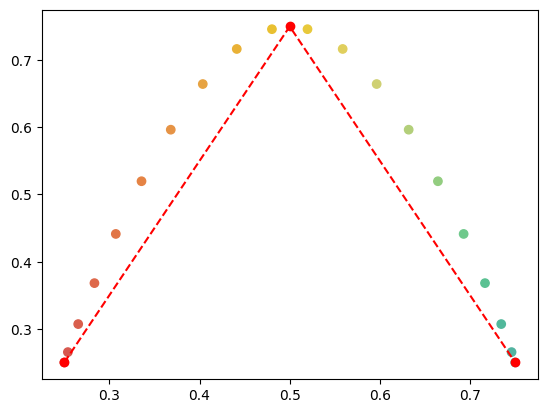

In [2]:
control_points = [(0.25, 0.25), (0.5, 0.75), (0.75, 0.25)]
sample_number = 20
texture_path = "example_texture.png"

# create a GenerateInfo object
info = dataset.GenerationInfo(
    spline_control_points=control_points,
    spline_sample_number=sample_number,
    texture_file_path=texture_path
)

# generate the dataset
example_dataset.create_dataset(generation_params=info)

# view the dataset, will be covered in the following sections
example_dataset.update_precision(32,8)
ax = example_dataset.plot_dataset(display=True)

### Increase readability with custom control point coordinates

Sometimes limit the control points to the unit square coordinate can be inconvienient. For example, supposing creating two control points at the `1/7` and `6/7` of the diagonal of the unit square. Hard-coding `1/7 = 0.142857` brings potential precision loss and is not readable. Alternatively, we can use two optional parameters of the `GenerationInfo` object to specify the coordinate of input control points.

Dataset created by Method 1:


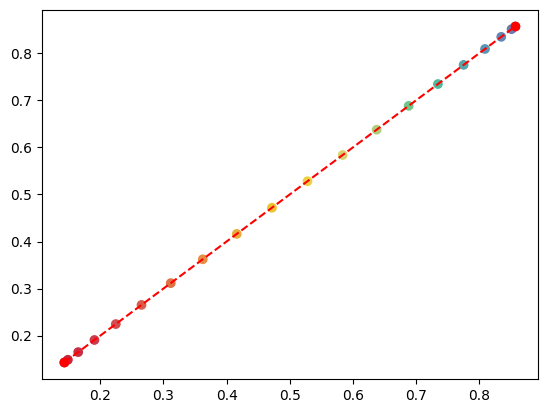

Dataset created by Method 2:


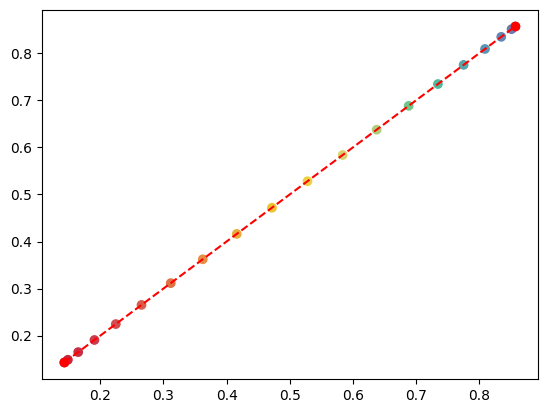

<Axes: >

In [3]:
# method 1, inconvienient
control_points_1 = [(0.142857, 0.142857), (0.857142,0.857142)]

# method 2, use optinal parameter to specify input coordinate
control_points_2 = [(1,1),(6,6)]
grid_width = 7
grid_height = 7

# create a view dataset
example_dataset.create_dataset(dataset.GenerationInfo(
    "example_texture.png",
    control_points_1,
    20
))
print("Dataset created by Method 1:")
example_dataset.plot_dataset()
example_dataset.create_dataset(generation_params=dataset.GenerationInfo(
    "example_texture.png",
    control_points_2,
    20,
    sample_grid_width=grid_width,
    sample_grid_height=grid_height,
))
print("Dataset created by Method 2:")
example_dataset.plot_dataset()

The results are same.

**NOTE**: `sample_grid_width` and `sample_grid_height` only scales the input control points, the sampled points will still be within the unit square coordinate regardless of these two parameters.

## Load, Saving and Cloning dataset

Once created, a dataset can be export to file at any time. A CSV file will be generated to store the sample points, as well as a JSON file to store dataset params.

Similarly, given a pair of these files, a dataset can be easily loaded.

By using the `clone` method, a new detached dataset instance with same content will be returned.

Dataset data saved to ./example_dataset.csv
Generation info saved to ./example_dataset_params.json


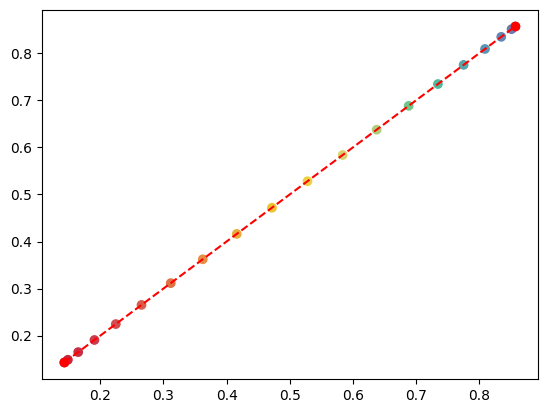

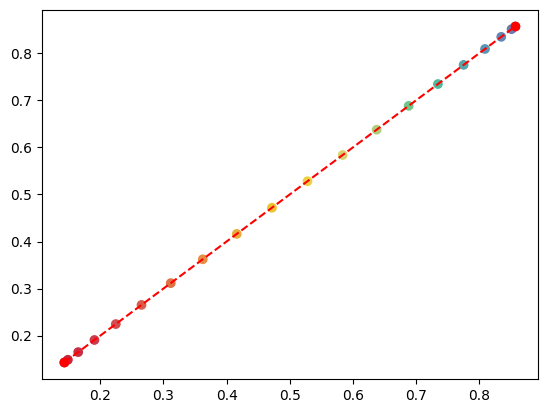

<Axes: >

In [4]:
# save
example_dataset.save_dataset(dataset_name="example_dataset", output_file_path="./")

# load
example_dataset.from_file("example_dataset")
example_dataset.plot_dataset()

# clone
cloned_example_dataset = example_dataset.clone()
cloned_example_dataset.plot_dataset()

## Masking and Exporting Dataset Records

The coordinates and colors of the sampled points are stored in a pandas DataFrame within the dataset object, which can be exported for further processing.

In [5]:
# export a copy of the point information
dataframe_copy = example_dataset.to_raw_data()

print(dataframe_copy[:5])

          x         y      r     g     b
0  0.142857  0.142857  194.0  37.0  56.0
1  0.148585  0.148585  195.0  39.0  60.0
2  0.164934  0.164934  198.0  46.0  67.0
3  0.190657  0.190657  204.0  59.0  76.0
4  0.224502  0.224502  209.0  76.0  81.0


A mask can be applied to the dataset to test the input reconstruction ability of neural networks. After applying the mask, the dataset can be exported as binary tensors or float tensors.

For binary tensors, the X, Y coordinates of the points and the R/G/B values are converted to binary and concatenated into a single tensor. Using `update_precision` method, the precision of the binary tensor can be adjusted. The default precision is 8 bits.

The float tensor is a 6-D tensor with each point represented as a 5-element vector: [X, Y, R, G, B]. The precision of the float tensor matches the precision of binary tensor, and can be adjusted using the `update_precision` method as well.

Ground truth:


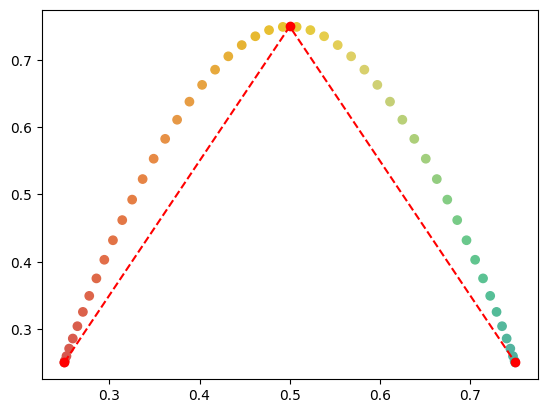

Export with high precision:


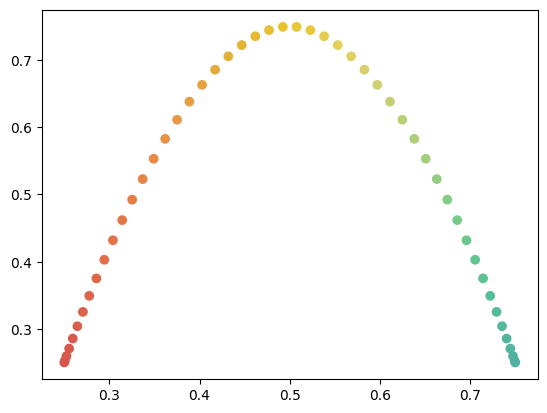

Export with low precision:


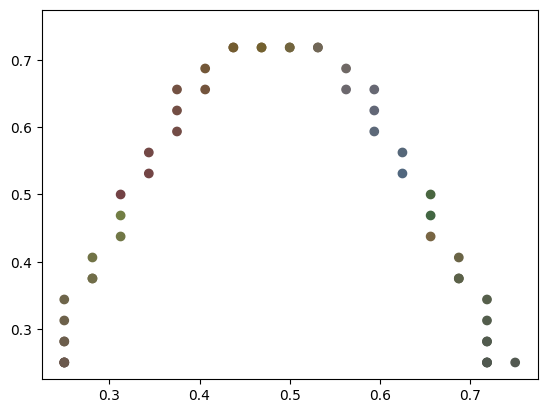

<Axes: >

In [6]:
example_dataset.create_dataset(dataset.GenerationInfo(
    "example_texture.png",
    control_points,
    50
))
print("Ground truth:")
example_dataset.plot_dataset()

# export point information to binary tensors with specified precision
print("Export with high precision:")
example_dataset.update_precision(coordinate_precision=32,color_precision=8)
tensors_high_pres = example_dataset.to_binary_tensors(masked=False)
example_dataset.plot_dataset(external_tensors=tensors_high_pres, raw_data_alpha=0)

print("Export with low precision:")
example_dataset.update_precision(6,7)
tensors_low_pres = example_dataset.to_binary_tensors()
example_dataset.plot_dataset(external_tensors=tensors_low_pres, raw_data_alpha=0)

Mask types include:

- `none`: No mask is applied.
- `coordinates`: Randomly mask the coordinates bits of the points to 0.
- `colors`: Randomly mask the color bits of the points to 0.
- `full`: Randomly mask the coordinates and color bits of the points to 0.

For each type of mask, a `mask_ratio` parameter can be specified to control the ratio of masked bits.

Export with mask:


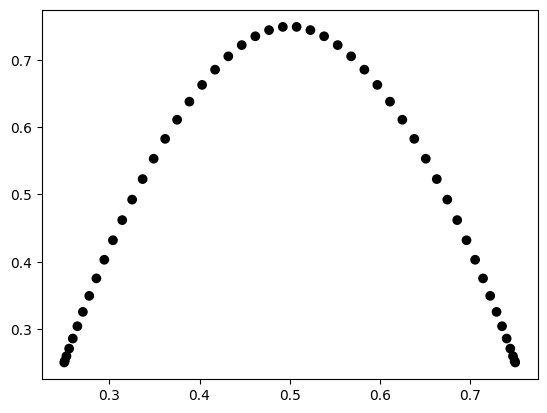

<Axes: >

In [7]:
# set mask by updating mask information
mask_info = dataset.MaskInfo(
    mask_type="colors",
    mask_ratio=1,
)
example_dataset.update_mask_info(mask_info=mask_info)

# export with mask
print("Export with mask:")
example_dataset.update_precision(32,8)
masked_tensors = example_dataset.to_binary_tensors(masked=True)
example_dataset.plot_dataset(external_tensors=masked_tensors, raw_data_alpha=0)

## Visualization and best practices

As shown in the earlier sections, the dataset can be visualized using the `plot_dataset` method. The `plot_dataset` method will plot the points on a 2-D grid, with the color of each point determined by the RGB value. The `plot_dataset` method can also save the plot as an image file without displaying it by setting the `display` and `save_as` options.

Display the dataset:


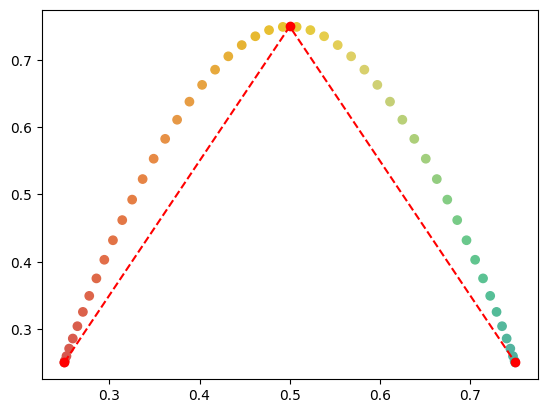

No display:
Save the figure:


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [8]:
# different ways to visualize the dataset
print("Display the dataset:")
ax = example_dataset.plot_dataset(display=True)
ax.figure.clear()
print("No display:")
ax = example_dataset.plot_dataset(display=False)
ax.figure.clear()
print("Save the figure:")
ax = example_dataset.plot_dataset(display=False, save_as="example_dataset_image.png")
ax.figure.clear()

Sometimes we want to compare a dataset with another input tensor, such as the input reconstruction result of a neuron network. This way, `plot_dataset` method can take an additional `external_tensor` as input. To distinguish the points from the dataset and the external tensor, the `raw_data_alpha` parameter can be used to adjust the transparency of the points from the dataset.

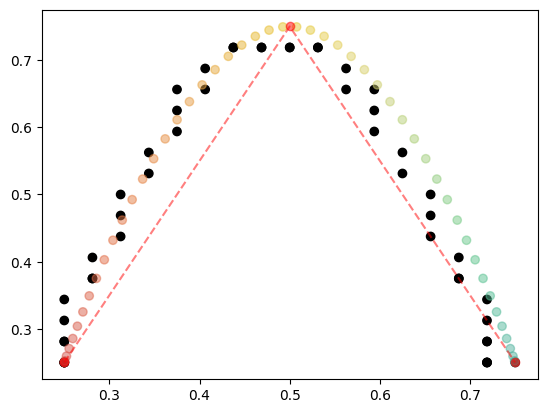

<Axes: >

In [9]:
# compare the dataset with external input tensors
example_dataset.update_precision(6,8)
example_dataset.update_mask_info(dataset.MaskInfo("colors",1))
tensors = example_dataset.to_binary_tensors(True)
example_dataset.plot_dataset(external_tensors=tensors, raw_data_alpha=0.5)

You may already notice that the `plot_dataset` method returns a Matplotlib `Axes` object. Acturally, `plot_dataset` can take in an `Axes` object as input, which allows you to plot dataset on a specific figure. If no `Axes` object is provided, a new figure will be created.

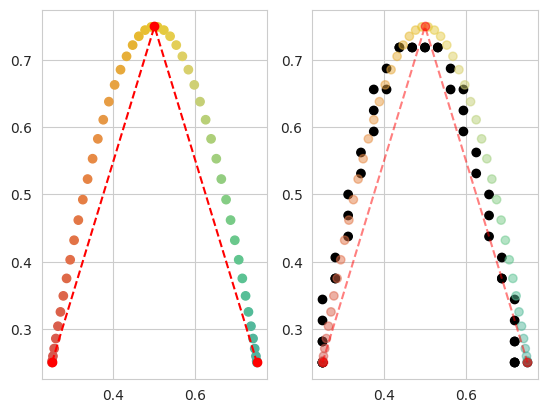

In [10]:
# use plot_dataset a part of figure plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
fig, axs = plt.subplots(1, 2)
axs[0] = example_dataset.plot_dataset(display=False, ax=axs[0])
axs[1] = example_dataset.plot_dataset(display=False, external_tensors=tensors, ax=axs[1], raw_data_alpha=0.5)

## Data Consistency

The last part is about the data consistency of dataset object. During this guide, we mainly operates on a single dataset instance. This illustrate that you can update dataset information at any time--but make sure to use member functions to do so. The dataset object will automatically update the internal data consistency. On the other hand, access attributes directly may lead to inconsistency.

In [11]:
# Do
example_dataset.create_dataset(dataset.GenerationInfo(
    "example_texture.png",
    [(0.25, 0.25), (0.5, 0.75), (0.75, 0.25)],
    37,
))

# Don't
example_dataset._generation_info.spline_sample_number = 37